In [37]:
import os
import cv2
#module to recursively search the files in directory
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import sys
#Suppress the warnings
import warnings
warnings.filterwarnings("ignore")

In [38]:
print("ok")

ok


In [39]:
#Set the hyperparamaters
#Image size of 32*32 
img_size=32
#color image with 3 channels - R,B,G
num_channels=3
#one image rep in flat 1 d = 32*32*3
img_size_flat=img_size*img_size*num_channels
#image shape 
img_shape=(img_size,img_size)
#Provide the training path for data
trainpath='./house_boat/train'
testpath='./house_boat/test'
labels={'house':0,'boat':1}

#size of output of fully connected layer
fc_size=32
num_steps=5



In [40]:
#Read the image data set
def read_images_classes(basepath,imgSize=img_size):
    #declare empty images and labels list
    image_stack=[]
    label_stack=[]
    
    #returns 0,house and 1,boat
    for counter,l in enumerate(labels):
        #path will be (basepath/label/g)
        path=os.path.join(basepath,l,'*g')
        for img in glob.glob(path):
            #one_hot_vector of zero's -> [0,0]
            one_hot_vector=np.zeros(len(labels),dtype=np.int16)
            #[0,0]->[1,0]->this is used for setting up corresponding label
            one_hot_vector[counter]=1
            #read the image
            image=cv2.imread(img)
            #Resize the image
            im_resize=cv2.resize(image,img_shape,interpolation=cv2.INTER_CUBIC)
            #Append the resized image to the image stack
            image_stack.append(im_resize)
            #Append the labels to label stack ->label with l -> house or boat , label[house]=0,label[boat]=1
            label_stack.append(labels[l])
        return np.array(image_stack),np.array(label_stack)

length of train image 20
X_data_shape (20, 32, 32, 3)
Y_data_shape (20,)


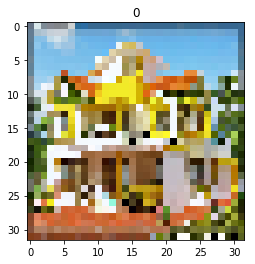

In [41]:
#Split into X,y
X_train,y_train=read_images_classes(trainpath)
X_test,y_test=read_images_classes(testpath)

#test a sample image
print("length of train image",len(X_train))
print('X_data_shape',X_train.shape)
print('Y_data_shape',y_train.shape)
#display an image with rgb format
plt.imshow(cv2.cvtColor(X_train[0],cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

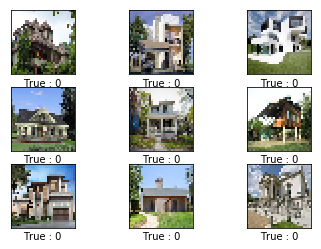

In [42]:
#Plot images
def plot_images(images,cls_true,cls_pred=None):
    if len(images)==0:
        print("No images to show")
        return
    else:
        #Pick up random sample from sequence of images [ random.sample(sequence,number)]
        random_indices=random.sample(range(len(images)),min(len(images),9))
        
     # images[rand],cls_true[random] -> images,cls_true -> correspoding label
    images,cls_true=zip(*[(images[i], cls_true[i]) for i in random_indices])
    #Create a figure with 3*3 subplots
    fig,axes=plt.subplots(3,3)
    #the amount of width reserved for space between subplots wspace,amunt of width horzantally is hspace
    #fig.subplots_adjust(hspace=0.3, wspace=0.3)
    #axes is an array of all axes
    #axes.flat will flat all the axes points.
    for i,ax in enumerate(axes.flat):
        #reshape the images into image size(32*32)
        image=images[i].reshape(img_size,img_size,num_channels)
        #convert to rgb values since originally is 
        image=cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        if cls_pred is None:
            xlabel="True : {0}".format(cls_true[i])
        else:
            xlabel="True:{0},pred:{1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel) # Show the classes as the label on the x-axis.
        ax.set_xticks([]) # Remove ticks from the plot.
        ax.set_yticks([])
    plt.show()

    # Plot some random images and their labels from the train set.
images, cls_true  = X_train, y_train
plot_images(images=images, cls_true=cls_true)

In [43]:
#Dfine the tensorflow model
### Define the tensorflow model
#The model should have the following layers
#- input later
#- conv layer 1 with 32 filters of kernel  size[5,5],
#- pooling layer 1 with pool size[2,2] and stride 2
#- conv layer 2 with 64 filters of kernel  size[5,5],
#- pooling layer 2 with pool size[2,2] and stride 2
#- dense layer whose output size is fixed in the hyper parameter: fc_size=32
#- drop out layer with droput probability 0.4
#- predict the class by doing a softmax on the output of the dropout layers

#Training
#- For training define the loss function and minimize it
#- For evaluation calculate the accuracy

#Reading Material
#- For ideas look at tensorflow layers tutorial on TensorFlow website

In [44]:
def cnn_model_fn(features, labels, mode):

    input_layer = tf.reshape(features["x"], [-1, img_size, img_size, num_channels]) #Should we have 1 channel

    # Convolutional Layer #1 and  Pooling layer 1
    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    layer_shape = pool2.get_shape()
    num_features = layer_shape[1:4].num_elements()

    pool2_flat = tf.reshape(pool2, [-1, num_features])
    
    dense = tf.layers.dense(inputs=pool2_flat, units=fc_size, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    print('dense shape',dense.get_shape())

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    print('logits shape',logits.get_shape())
    print('labels shape',labels.get_shape())

    predictions = {"classes": tf.argmax(input=logits, axis=1),
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:       
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [45]:
#Run the tensorflow model
X_train_std = np.array((X_train/255.0),dtype=np.float32)
X_test_std = np.array((X_test/255.0), dtype=np.float32)

#creat an estmator model using the cnn model defin-ed.
house_boat_classifier=tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir="/tmp/house_boat_convnet_model")

tensors_to_log={"probablities":"softmax_tensor"}
#log the details of the above tensors
logging_hook=tf.train.LoggingTensorHook(tensors=tensors_to_log,every_n_iter=50)

#feed the data into the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train_std}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
#Train the function
house_boat_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])

#
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test_std}, y=y_test, num_epochs=1,shuffle=False)

eval_results = house_boat_classifier.evaluate(input_fn=eval_input_fn)

print(eval_results)

redict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test_std}, num_epochs=1,shuffle=False)
predict_results = house_boat_classifier.predict(input_fn=predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/house_boat_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000029709235A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipeli

NameError: name 'predict_input_fn' is not defined